In [1]:
from plaidml.keras import install_backend
install_backend()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from code.util import *

In [2]:
N_VOCAB = 4000
N_CLASS = 2
BATCH_SIZE = 512
EPOCHS = 100

In [3]:
x = load("data/x_word.pkl")
y = load("data/y_onehot.pkl")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

In [5]:
print(x.shape, y.shape)

(127284, 24) (127284, 2)


In [11]:
model_input = Input(shape=(x.shape[1], ))
H = Embedding(N_VOCAB, 32)(model_input)
H = SpatialDropout1D(0.25)(H)
H = LSTM(32)(H)
model_output = Dense(N_CLASS, activation="softmax")(H)

model = Model(model_input, model_output)
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 24, 32)            128000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 24, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 136,386
Trainable params: 136,386
Non-trainable params: 0
_________________________________________________________________


In [12]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[es]
)

score = model.evaluate(x_test, y_test, verbose=0)

Train on 89098 samples, validate on 38186 samples
Epoch 1/100
89098/89098 [==============================] - 8s 86us/sample - loss: 0.2794 - accuracy: 0.8932 - val_loss: 0.1024 - val_accuracy: 0.9644
Epoch 2/100
89098/89098 [==============================] - 6s 71us/sample - loss: 0.0875 - accuracy: 0.9711 - val_loss: 0.0861 - val_accuracy: 0.9721
Epoch 3/100
89098/89098 [==============================] - 6s 71us/sample - loss: 0.0733 - accuracy: 0.9765 - val_loss: 0.0772 - val_accuracy: 0.9751
Epoch 4/100
89098/89098 [==============================] - 6s 72us/sample - loss: 0.0672 - accuracy: 0.9790 - val_loss: 0.0788 - val_accuracy: 0.9749
Epoch 5/100
89098/89098 [==============================] - 6s 71us/sample - loss: 0.0645 - accuracy: 0.9799 - val_loss: 0.0751 - val_accuracy: 0.9759
Epoch 6/100
89098/89098 [==============================] - 6s 72us/sample - loss: 0.0613 - accuracy: 0.9808 - val_loss: 0.0736 - val_accuracy: 0.9767
Epoch 7/100
89098/89098 [=========================

In [13]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07347727091321041
Test accuracy: 0.97664064


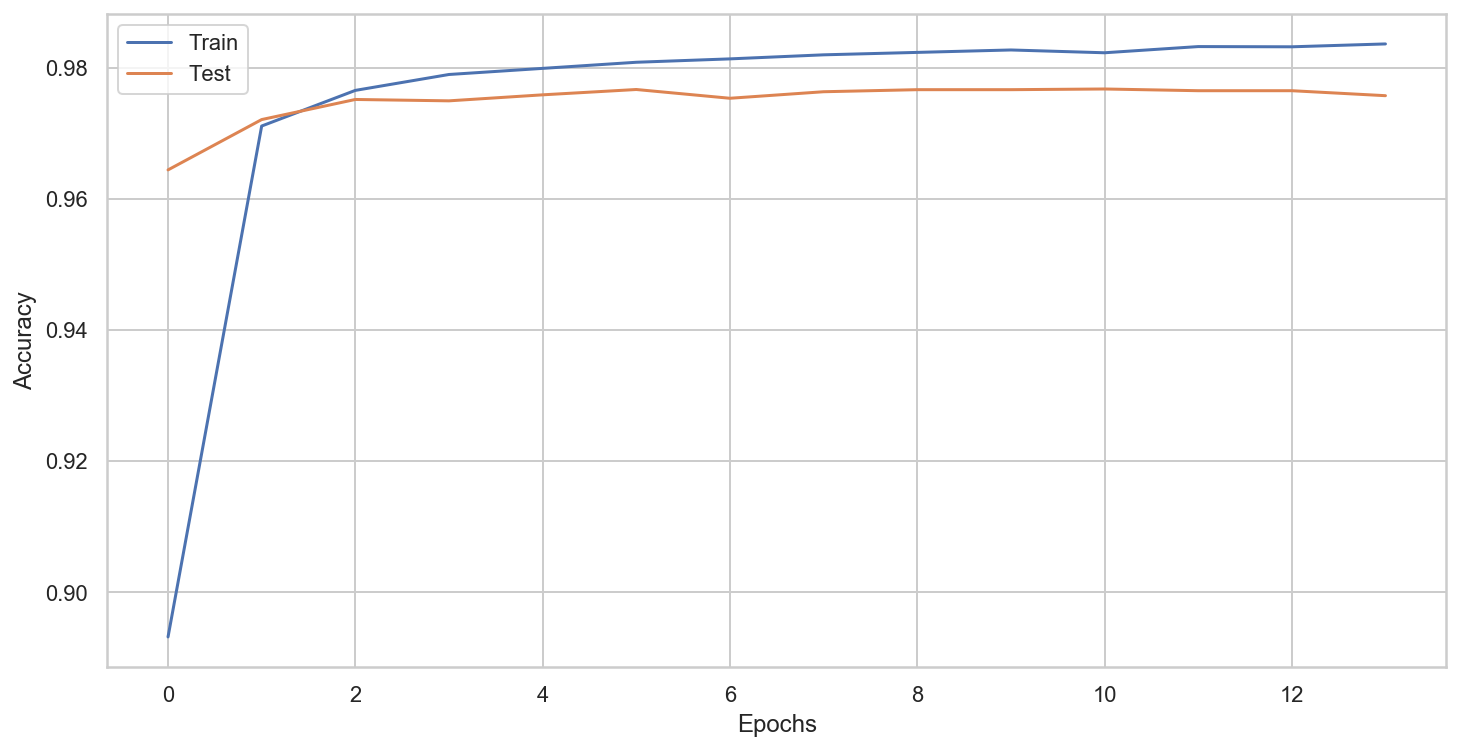

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [10]:
model.save("models/lstm_word.h5")